In [234]:
import numpy as np
import scipy.signal as signal
import sounddevice as sd
import soundfile as sf
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import cPickle
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Define Basic Voice Activation Detector

In [17]:
class VoiceActivityDetector():   
    def __init__(self, fs):
        self.sample_rate = fs
        self.sample_rate = 44100
        self.speech_on = False
    
        #Spectrum Based:
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
    
    def CheckActivation(self, data):
        speech_band_energy_fraction = self.GetSpeechBandEnergyFraction(data)
        self.speech_on = self.ClassifySpeech(speech_band_energy_fraction)
    
    def FreqInRange(self, f):
        return freq[i] > self.speech_start_band and freq[i] < self.speech_end_band
    
    def GetSpeechBandEnergyFraction(self,data):
        freq, power = signal.periodogram(data, self.sample_rate)
        total_energy = np.sum(power)
        in_range = lambda (f) : (f > self.speech_start_band) and (f < self.speech_end_band)
        band_energy = sum([power[i] for i in range(len(power)) if in_range(freq[i])]) 
        return band_energy / total_energy
    
    def ClassifySpeech(self, speech_band_energy_fraction):
        return (speech_band_energy_fraction > self.speech_energy_threshold)





In [14]:
[fs, data] = wavfile.read('wav-sample.wav')
VAD = VoiceActivityDetector(fs)

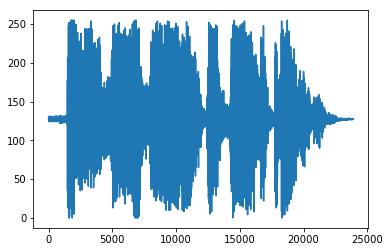

In [12]:
plt.plot(fs)
plt.show()

In [18]:
VAD.GetSpeechBandEnergyFraction(data)

0.56571829459821688

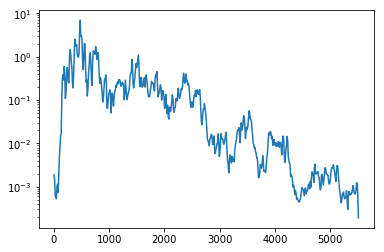

In [19]:
f, Pxx_den = signal.welch(data, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.show()

# Record Speech Examples:

In [120]:


fs = 44100  # Sample rate
seconds = 30  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
#write('speech.wav', fs, myrecording)  # Save as WAV file 

In [121]:
wavfile.write('TrainingData/non_speech.wav', fs, myrecording)  # Save as WAV file 

In [114]:
fs = 44100  # Sample rate
duration = 0.2  # seconds
sound_recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sound_recording = np.transpose(sound_recording)[0]

In [115]:
freq, power = signal.periodogram(sound_recording, fs)
total_energy = np.sum(power)
in_range = lambda (f) : (f > 300) and (f < 2000)
band_energy = np.sum([power[i] for i in range(len(power)) if in_range(freq[i])]) 
print band_energy / total_energy

0.00922368


In [113]:
power[0]

1.3840417e-22

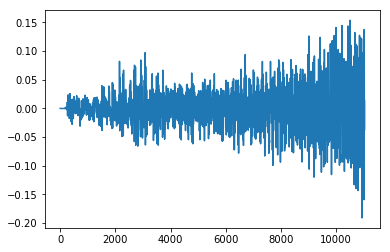

In [111]:
plt.plot(sound_recording)
plt.show()

# Train Model

In [243]:
#Load Sounds:
fs = 44100  # Sample rate
duration = 0.2
[fs, speech_recording] = wavfile.read('TrainingData/speech.wav', )
[fs, ambient_recording] = wavfile.read('TrainingData/non_speech.wav')

In [244]:
np.size(speech_recording[1000:1010,0])

10

In [245]:
def Sound2Blocks(x, fs, block_duration):
    sample_length = int(fs * block_duration)
    n_samples = len(x) / sample_length
    samples = []
    for i in range(n_samples):
        block = x[(i*sample_length):((i+1)*sample_length),0]
        samples.append(block)
    return samples

In [246]:
def ExtractPowerBands(x, fs, band_bins):
    freq, power = signal.periodogram(x, fs)
    total_energy = np.sum(power)
    band_energy_fraction = [0.0] * (len(band_bins))
    band_ind = 0
    for i in range(len(power)):
        if(freq[i]>band_bins[band_ind]):
            band_ind += 1
        band_energy_fraction[band_ind] += power[i]
    normalized_band_energy = [b / total_energy for b in band_energy_fraction]
    return normalized_band_energy

In [247]:
speech_blocks = Sound2Blocks(speech_recording, fs, duration)
non_speech_blocks = Sound2Blocks(ambient_recording,fs, duration)
band_bins = [180, 250, 360, 500, 1000, 2000, 5000, 10000, 25000]
X = []
prior_bands = [0.0]*len(band_bins)
for block in speech_blocks:
    bands = ExtractPowerBands(block, fs, band_bins)
    if(prior_bands[0] != 0.0):
        bands.extend(prior_bands)
        X.append(bands)
    prior_bands = bands[0:len(band_bins)]
    
prior_bands = [0.0]*len(band_bins)
for block in non_speech_blocks:
    bands = ExtractPowerBands(block, fs, band_bins)
    if(prior_bands[0] != 0.0):
        bands.extend(prior_bands)
        X.append(bands)
    prior_bands = bands[0:len(band_bins)]
is_speech = [True] * (len(speech_blocks) - 1)
isnot_speech = [False] * (len(non_speech_blocks) - 1)
is_speech.extend(isnot_speech)

In [248]:
clf = SVC()
clf.fit(X, is_speech)
print clf.score(X, is_speech)

0.825503355705


In [249]:
c_range = np.logspace(-2,10,13)
gamma_range = np.logspace(-9,3,13)
parameter_grid = dict(gamma = gamma_range, C = c_range)

In [250]:
cv = StratifiedShuffleSplit(n_splits = 3, test_size= 0.25)
scoring_metric = metrics.make_scorer(metrics. precision_score)
grid = GridSearchCV(SVC(), param_grid=parameter_grid, cv = cv, scoring=scoring_metric)
grid.fit(X,is_speech)

/Users/benjaminlucas/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.25,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make

In [251]:
grid.best_params_

{'C': 10000000.0, 'gamma': 0.001}

In [252]:
grid.best_score_

0.90161276631864851

In [253]:
grid.best_estimator_

SVC(C=10000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

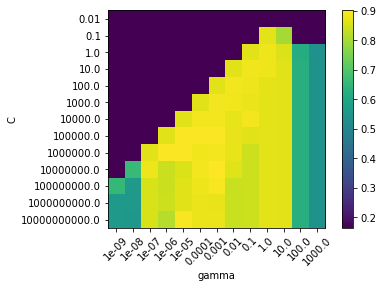

In [254]:
scores = grid.cv_results_['mean_test_score'].reshape(len(c_range), len(gamma_range))
plt.imshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation = 45)
plt.yticks(np.arange(len(c_range)), c_range)
plt.colorbar()
plt.show()

## Save Model:

In [255]:
band_bins = [180, 250, 360, 500, 1000, 2000, 5000, 10000, 25000]
prior_bands = [0.0]*len(band_bins)
clf = grid.best_estimator_
clf.fit(X,is_speech)
clf.predict(np.reshape([0.0]*2*len(band_bins),(1,18)))[0]

False

In [256]:
with open('svm_classifier.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)